# Analiza średnich temperatur dziennych w Madrycie

średnich temperatur dziennych analiza madrycka

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

sns.set_style('darkgrid')

from statsmodels.tsa.arima_process import ArmaProcess, arma_acovf, arma_acf, arma_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acovf, acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from scipy.stats import norm, probplot, kstest,  shapiro

## Przygotowanie danych

In [2]:
data_path_madrid = 'madrid.csv'
madrid_data = pd.read_csv(data_path_madrid)

madrid_data.head()

,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,Europe,Spain,NaN,Madrid,5,13,2017,61.0
1,Europe,Spain,NaN,Madrid,5,14,2017,63.2
2,Europe,Spain,NaN,Madrid,5,15,2017,66.8
3,Europe,Spain,NaN,Madrid,5,16,2017,73.7
4,Europe,Spain,NaN,Madrid,5,17,2017,72.3


Na tym etapie stwierdzamy, że `Region`, `Country` i `State` nie są nam potrzebne

In [3]:
madrid_data = madrid_data.drop('Region', axis=1)
madrid_data = madrid_data.drop('Country', axis=1)
madrid_data = madrid_data.drop('State', axis=1)

madrid_data

,City,Month,Day,Year,AvgTemperature
0,Madrid,5,13,2017,61.0
1,Madrid,5,14,2017,63.2
2,Madrid,5,15,2017,66.8
3,Madrid,5,16,2017,73.7
4,Madrid,5,17,2017,72.3
...,...,...,...,...,...
1092,Madrid,5,9,2020,67.0
1093,Madrid,5,10,2020,60.1
1094,Madrid,5,11,2020,60.6
1095,Madrid,5,12,2020,55.3


`Month`, `Day`, `Year` i `AvgTemperature` to liczby

In [4]:
madrid_data["Month"] = pd.to_numeric(madrid_data["Month"])
madrid_data["Day"] = pd.to_numeric(madrid_data["Day"])
madrid_data["Year"] = pd.to_numeric(madrid_data["Year"])
madrid_data["AvgTemperature"] = pd.to_numeric(madrid_data["AvgTemperature"])

Coś tam z datą 

In [5]:
madrid_data['Date'] = pd.to_datetime(madrid_data[['Year', 'Month', 'Day']])

madrid_data = madrid_data.sort_values(by='Date')

madrid_data

,City,Month,Day,Year,AvgTemperature,Date
0,Madrid,5,13,2017,61.0,2017-05-13
1,Madrid,5,14,2017,63.2,2017-05-14
2,Madrid,5,15,2017,66.8,2017-05-15
3,Madrid,5,16,2017,73.7,2017-05-16
4,Madrid,5,17,2017,72.3,2017-05-17
...,...,...,...,...,...,...
1092,Madrid,5,9,2020,67.0,2020-05-09
1093,Madrid,5,10,2020,60.1,2020-05-10
1094,Madrid,5,11,2020,60.6,2020-05-11
1095,Madrid,5,12,2020,55.3,2020-05-12


Zobaczmy jak dane się prezentują na wykresie

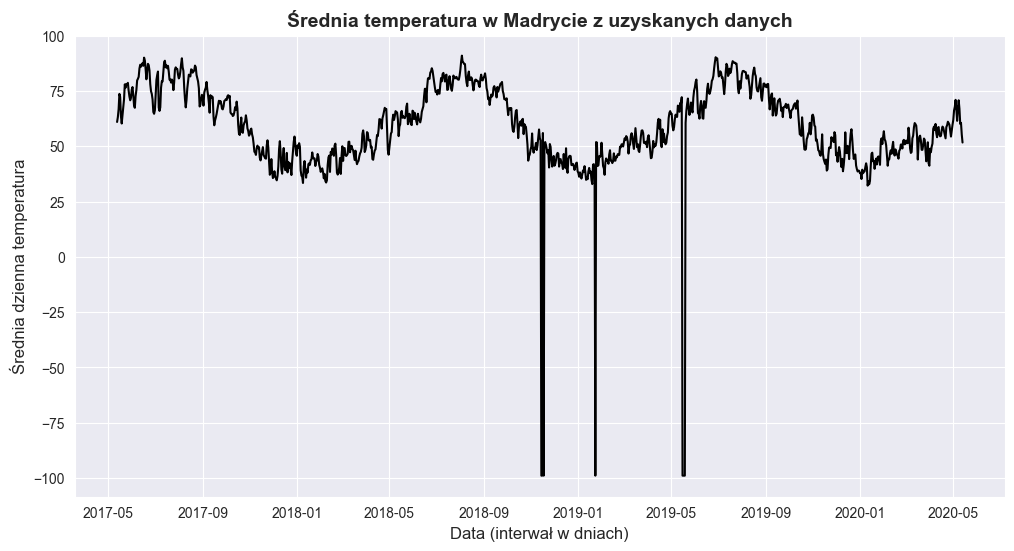

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(madrid_data['Date'], madrid_data['AvgTemperature'],color = 'black')

plt.title('Średnia temperatura w Madrycie z uzyskanych danych',fontsize=14, fontweight='bold')

plt.xlabel('Data (interwał w dniach)',fontsize=12)
plt.ylabel('Średnia dzienna temperatura',fontsize=12)

plt.show()

### Brakujące wartości

Widzimy teraz pewne problemy. W uzyskanych danych badacze nie zmierzeli danych dla wybranych konkretnych przypadkowych dni co powoduje problem.

Dodatkowo temperatura jest prawdopodobnie w Farenheitach 

In [7]:
madrid_data[madrid_data.AvgTemperature < -75].head()

,City,Month,Day,Year,AvgTemperature,Date
550,Madrid,11,14,2018,-99.0,2018-11-14
551,Madrid,11,15,2018,-99.0,2018-11-15
553,Madrid,11,17,2018,-99.0,2018-11-17
620,Madrid,1,23,2019,-99.0,2019-01-23
733,Madrid,5,16,2019,-99.0,2019-05-16


hahahhahhahahahhah

Potwierdza się hipoteza, `-99` to wartość kiedy prawdopodobnie temp. nie została zmierzona bo mija się to z prawdą. Zmienimy je na średnią z 5 sasiądujących dni.
`brakujący dzień = 1/4 (-2 dzień + -1 dzień + +1 dzień + +2dzień)`

In [8]:
madrid_data['AvgTemperature_New'] = madrid_data['AvgTemperature']

for i in range(len(madrid_data)):
    if madrid_data.at[i, 'AvgTemperature'] == -99.0:
        start_index = max(0, i - 2)
        end_index = min(len(madrid_data), i + 2)
        neighbors = madrid_data['AvgTemperature'].loc[start_index:end_index]
        neighbors_without_minus_99 = neighbors[neighbors != -99.0]
        madrid_data.at[i, 'AvgTemperature_New'] = round(neighbors_without_minus_99.mean(), 2)

madrid_data['AvgTemperature'] = madrid_data['AvgTemperature_New']
madrid_data = madrid_data.drop('AvgTemperature_New', axis=1)

madrid_data[madrid_data.AvgTemperature < -75].head()

,City,Month,Day,Year,AvgTemperature,Date


Puste wiersze z złymi danymi => więc się zgadza. 

Zobaczmy wykres po tych modyfikacjach

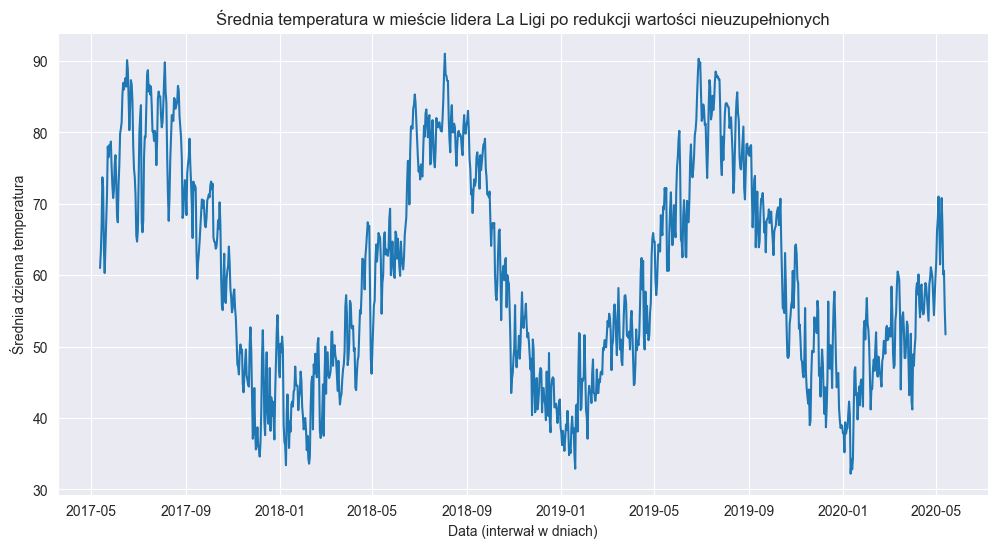

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(madrid_data['Date'], madrid_data['AvgTemperature'])

plt.title('Średnia temperatura w mieście lidera La Ligi po redukcji wartości nieuzupełnionych')

plt.xlabel('Data (interwał w dniach)')
plt.ylabel('Średnia dzienna temperatura')

plt.show()

### Konwersja stopni

Wartości są mniej niepokojące, jednak 90 stopni nie jest możliwe. Zauważmy że $100$ stopni Farenheita to $37.7$ Celcjusza co miałoby większy sens ale maksimum.

Wzór konwersji z Farenheita na Celsjusza to:
$$
(F - 32) \cdot \frac{5}{9}
$$

In [10]:
def fahrenheit_to_celsius(fahrenheit):
    return (fahrenheit - 32) * (5/9)


madrid_data['AvgTemperature'] = madrid_data['AvgTemperature'].apply(fahrenheit_to_celsius)

Ponownie spójrzmy na wykres

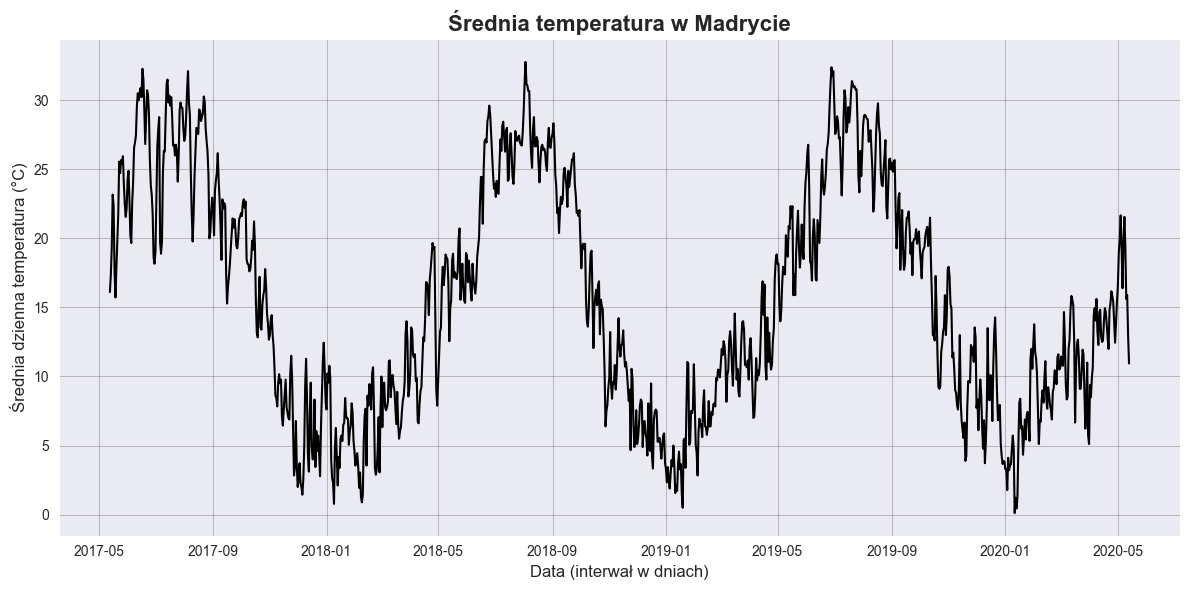

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(madrid_data['Date'], madrid_data['AvgTemperature'], color='black', linewidth=1.5)

plt.title('Średnia temperatura w Madrycie', fontsize=16, fontweight='bold')

plt.xlabel('Data (interwał w dniach)', fontsize=12)
plt.ylabel('Średnia dzienna temperatura (°C)', fontsize=12)
plt.grid(color='gray', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

Takie dane wyglądają jak najbadziej sensownie i realnie - mamy więc z czym pracować.

# Zbadanie jakości danych

Średnia: 15.597412134103108
Odchylenie standardowe: 8.263092461953267
Mediana: 14.666666666666666
Liczba obserwacji: 1097
Minimum: 0.1111111111111127
Maksimum: 32.77777777777778


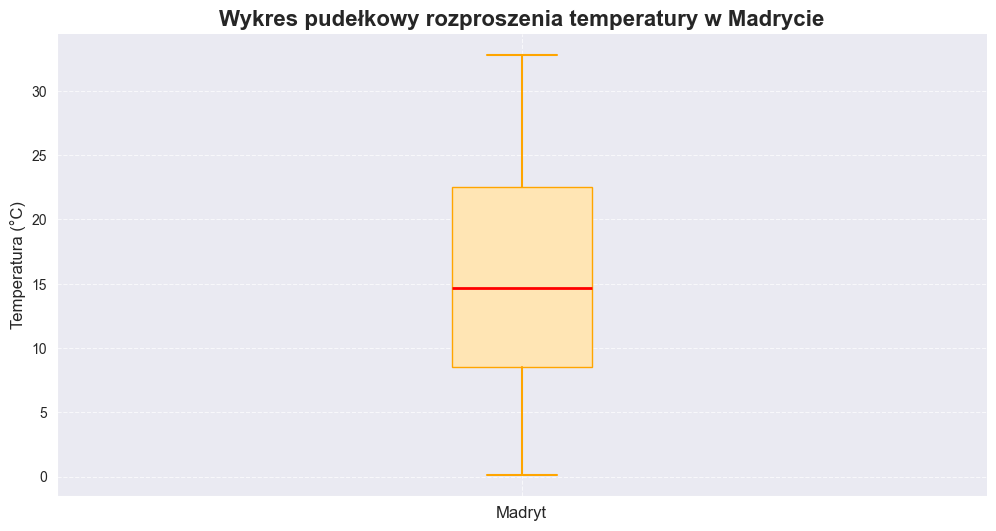

In [49]:
data = madrid_data['AvgTemperature']
srednia = np.mean(data)
odchylenie = np.std(data)
mediana = np.median(data)
ilosc_danych = len(data)
minimum = np.min(data)
maksimum = np.max(data)

print(f"Średnia: {srednia}")
print(f"Odchylenie standardowe: {odchylenie}")
print(f"Mediana: {mediana}")
print(f"Liczba obserwacji: {ilosc_danych}")
print(f"Minimum: {minimum}")
print(f"Maksimum: {maksimum}")


plt.figure(figsize=(12, 6))

box = plt.boxplot(
    data, 
    patch_artist=True, 
    boxprops=dict(facecolor='#ffe5b4', color='orange'), 
    whiskerprops=dict(color='orange', linewidth=1.5), 
    capprops=dict(color='orange', linewidth=1.5), 
    medianprops=dict(color='red', linewidth=2)
)

plt.title('Wykres pudełkowy rozproszenia temperatury w Madrycie', fontsize=16, fontweight='bold')
plt.ylabel('Temperatura (°C)', fontsize=12)
plt.xticks(ticks=[1], labels=['Madryt'], fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

# Autokowariancja i autokorelacja empiryczna dla surowych danych:

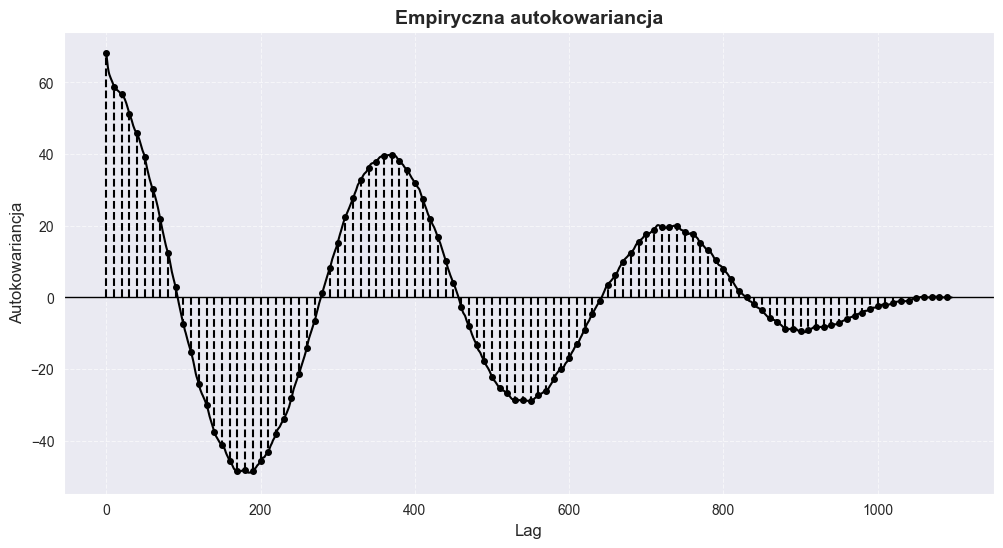

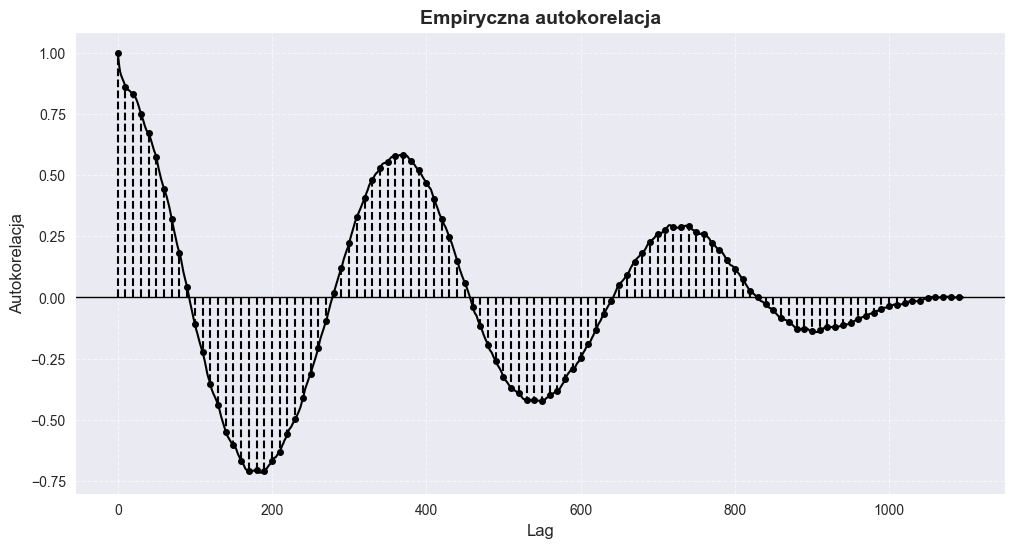

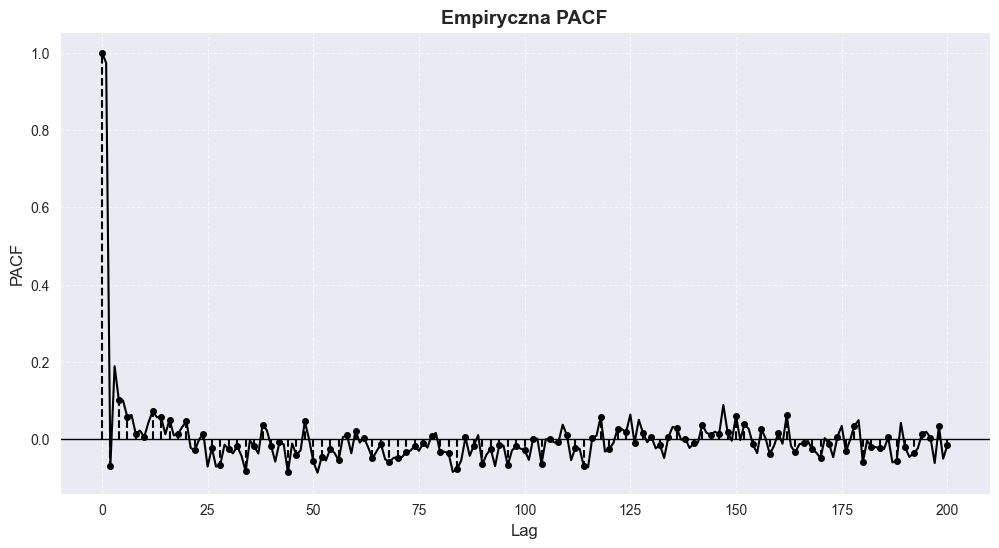

In [50]:
dane_surowe = madrid_data['AvgTemperature']
n = len(dane_surowe)
h_max = 200
acovf_surowe = acovf(dane_surowe, fft=True)
acf_emp_surowe = acf(dane_surowe, fft=True, nlags=n)
pacf_emp_surowe = pacf(dane_surowe, nlags = h_max, method='yw')


lags = np.arange(0,n)
lags_pacf = np.arange(0,h_max+1)
step = 10

lags_sub = lags[::step]
acf_sub  = acf_emp_surowe[::step]
acvf_sub = acovf_surowe[::step]


plt.figure(figsize=(12, 6))
plt.plot(lags,acovf_surowe, 'k-')

markers_acvf = plt.stem(lags_sub, acvf_sub, basefmt=' ')
plt.setp(markers_acvf[0], marker='o', markersize=4, color='black')
plt.setp(markers_acvf[1], linestyle='--', color='black')

plt.xlabel('Lag',fontsize=12)
plt.ylabel('Autokowariancja',fontsize=12)
plt.title('Empiryczna autokowariancja', fontsize=14, fontweight='bold')
plt.grid(alpha=0.6, linestyle='--')
plt.axhline(y=0, color='black', linewidth=1)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(lags, acf_emp_surowe,'k-')
markers_acf = plt.stem(lags_sub, acf_sub, basefmt=' ')
plt.setp(markers_acf[0], marker='o', markersize=4, color='black')
plt.setp(markers_acf[1], linestyle='--', color='black')
plt.xlabel('Lag',fontsize=12)
plt.ylabel('Autokorelacja',fontsize=12)
plt.title('Empiryczna autokorelacja', fontsize=14, fontweight='bold')
plt.grid(alpha=0.6, linestyle='--')
plt.axhline(y=0, color='black', linewidth=1)
plt.show()

step = 2 


lags_sub2 = lags_pacf[::step]
pacf_sub  = pacf_emp_surowe[::step]

plt.figure(figsize=(12, 6))

plt.plot(lags_pacf, pacf_emp_surowe, 'k-')

markers_pacf = plt.stem(lags_sub2, pacf_sub, basefmt=' ')
plt.setp(markers_pacf[0], marker='o', markersize=4, color='black')
plt.setp(markers_pacf[1], linestyle='--', color='black')


plt.axhline(y=0, color='black', linewidth=1)
plt.title("Empiryczna PACF",fontsize=14, fontweight='bold')
plt.xlabel("Lag",fontsize=12)
plt.ylabel("PACF",fontsize=12)
plt.grid(alpha=0.6, linestyle='--')
plt.show()


Test ADF (Augmented Dickey-Fuller) w celu weryfikacji hipotezy o niestacjonarności danych czasowych

In [51]:
def adfuller_test(series, sig = 0.05):
    res = adfuller(series, autolag='AIC')    
    p_value = round(res[1], 3) 
    stats   = round(res[0], 3) 

    if p_value <= sig:
        print(f"Statystyka testowa = {stats}, p-Value = {p_value} => Stationary. ")
    else:
        print(f"Statystyka testowa = {stats}, p-value = {p_value} => Non-stationary.")

In [52]:
dane_surowe = madrid_data['AvgTemperature']
adfuller_test(dane_surowe)

Statystyka testowa = -1.939, p-value = 0.314 => Non-stationary.


Interpretacja:
Porównanie ADF Statistic z wartościami krytycznymi:

1. Wartość statystyki  ADF=−1.9393 jest większa (mniej ujemna) niż wszystkie wartości krytyczne (
−3.4364, −2.8642, −2.5682). To sugeruje brak wystarczających dowodów na odrzucenie hipotezy zerowej.
2. p-value:
Wartość p=0.3138 jest większa niż typowy poziom istotności (0.05). Oznacza to, że nie możemy odrzucić hipotezy zerowej o niestacjonarności danych.

Wniosek: Dane są niestacjonarne. Aby móc zastosować model ARMA, należy przekształcić dane, by stały się stacjonarne. I po to kolejne kroki w raporcie.

No i teraz cykamy te metody, zad 4 z L5 bylo podobne do jej kodow i chyba dawalo ten sam efekt, więc bazujmy na jej kodzie do tego.

U niej bylo na sztywno wybrane jakies 0.1*t, wiec u nas musi byc dopasowane do danych, chat tak proponuje.

[10.29442031  0.01731905  0.3263944  -0.03093981]


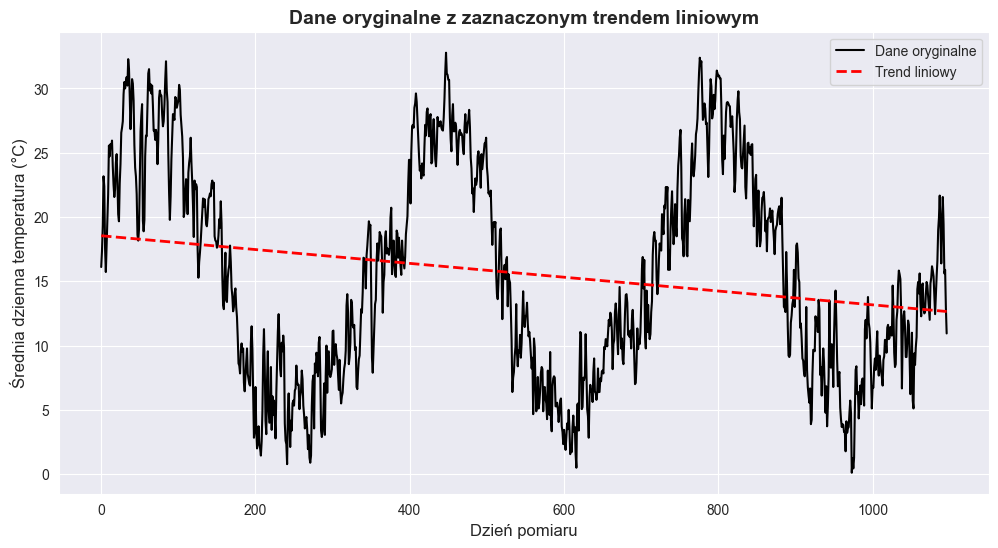

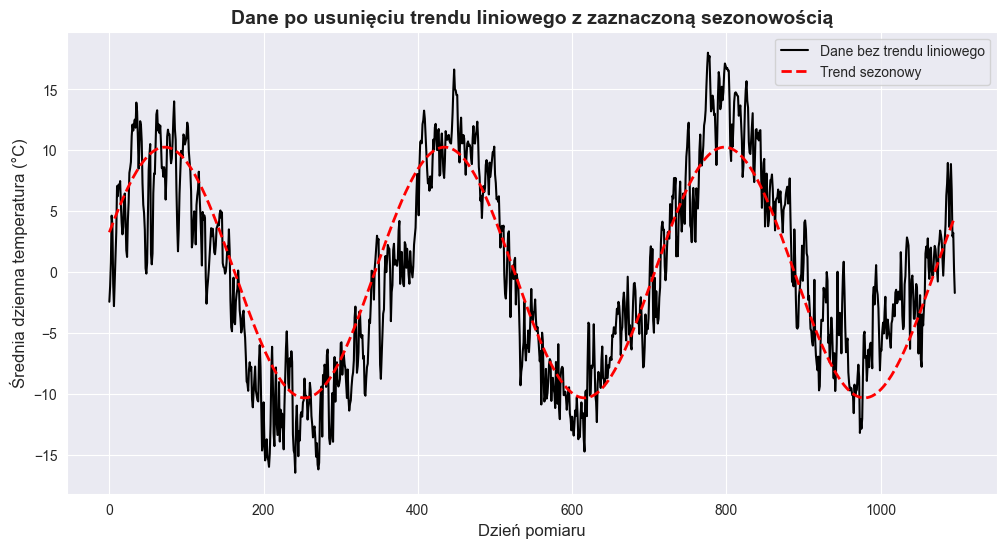

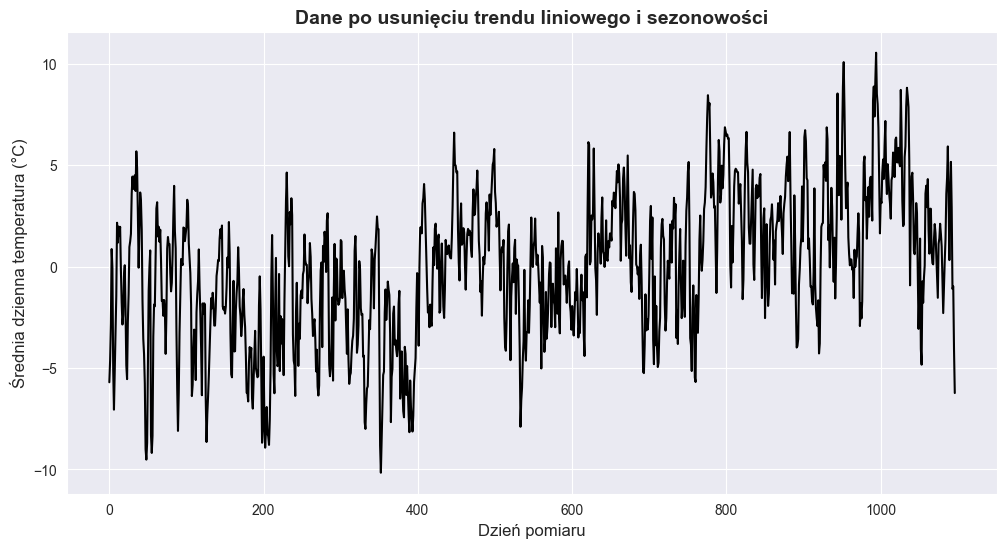

In [53]:
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
time = np.arange(len(madrid_data))
temperature = madrid_data['AvgTemperature'].values

linear_reg = LinearRegression()
linear_reg.fit(time.reshape(-1, 1), temperature)
trend_predicted = linear_reg.predict(time.reshape(-1, 1))
temperature_without_linear_trend = temperature - trend_predicted

def sine_func(x, A, omega, phi, offset):
    """
    A       – amplituda
    omega   – częstotliwość (np. 2π/365 dla danych dziennych o rocznej cykliczności)
    phi     – przesunięcie fazowe (w radianach)
    offset  – przesunięcie w pionie (średni poziom)
    """
    return offset + A * np.sin(omega * x + phi)

p0 = [
    10,          # amplituda początkowa
    2 * np.pi/365, # częstotliwość (jeśli dane są dzienne i spodziewamy się roku)
    0,           # faza startowa
    0            # offset (śr. poziom)
]
params, _ = curve_fit(sine_func, time, temperature_without_linear_trend, p0=p0)
print(params)
fitted_sine_wave = sine_func(time, *params)
temperature_without_seasonal = temperature_without_linear_trend - fitted_sine_wave


# Wykres trendu liniowego
plt.figure(figsize=(12, 6))
plt.plot(madrid_data['AvgTemperature'], label='Dane oryginalne', color = 'black',linewidth = 1.5)
plt.plot(trend_predicted, label='Trend liniowy', linestyle='--', color='red', linewidth=2)
plt.title('Dane oryginalne z zaznaczonym trendem liniowym' ,fontsize=14, fontweight='bold')
plt.xlabel('Dzień pomiaru', fontsize=12)
plt.ylabel('Średnia dzienna temperatura (°C)', fontsize=12)
plt.legend()
plt.show()

# Wykres danych po usunięciu trendu liniowego z zaznaczoną sezonowością
plt.figure(figsize=(12, 6))
plt.plot(madrid_data.index, temperature_without_linear_trend, label='Dane bez trendu liniowego', color = 'black',linewidth = 1.5)
plt.plot(madrid_data.index, fitted_sine_wave, label='Trend sezonowy', linestyle='--', color='red', linewidth=2)
plt.title('Dane po usunięciu trendu liniowego z zaznaczoną sezonowością', fontsize=14, fontweight='bold')
plt.xlabel('Dzień pomiaru', fontsize=12)
plt.ylabel('Średnia dzienna temperatura (°C)', fontsize=12)
plt.legend()
plt.show()

# Wykres danych po usunięciu trendu liniowego i sezonowości
plt.figure(figsize=(12, 6))
plt.plot(madrid_data.index, temperature_without_seasonal,color = 'black', linewidth = 1.5)
plt.title('Dane po usunięciu trendu liniowego i sezonowości', fontsize=14, fontweight='bold')
plt.xlabel('Dzień pomiaru', fontsize=12)
plt.ylabel('Średnia dzienna temperatura (°C)', fontsize=12)
plt.show()


## Sprawdzenie adf dla danych po usunieciu trendu i po usunięciu sezonowości:

In [54]:
print('ADF test dla danych bez trendu liniowego (z sezonowością):')
adfuller_test(temperature_without_linear_trend)


dane_bez_sezonowosci = temperature - fitted_sine_wave
print('\nADF test dla danych bez sezonowości (z trendem liniowym):')
adfuller_test(dane_bez_sezonowosci)


ADF test dla danych bez trendu liniowego (z sezonowością):
Statystyka testowa = -1.899, p-value = 0.332 => Non-stationary.

ADF test dla danych bez sezonowości (z trendem liniowym):
Statystyka testowa = -9.949, p-Value = 0.0 => Stationary. 


## Sprawdzenie adf testem po usunięciu trendu i sezonowości:

In [55]:
data_cooked = temperature_without_seasonal

adfuller_test(data_cooked)

Statystyka testowa = -7.083, p-Value = 0.0 => Stationary. 


# Autokowariancja i autokorelacja empiryczna dla przekształconych danych:

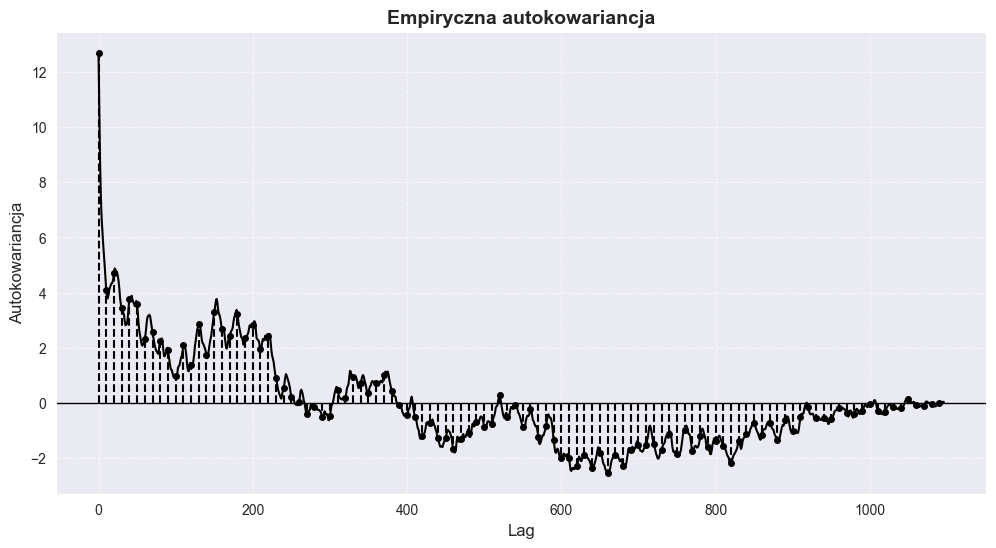

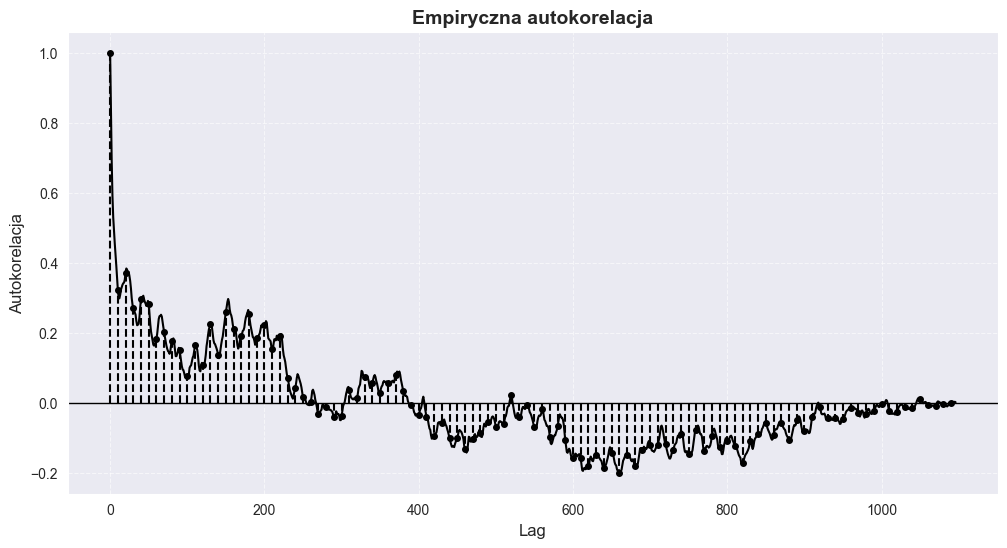

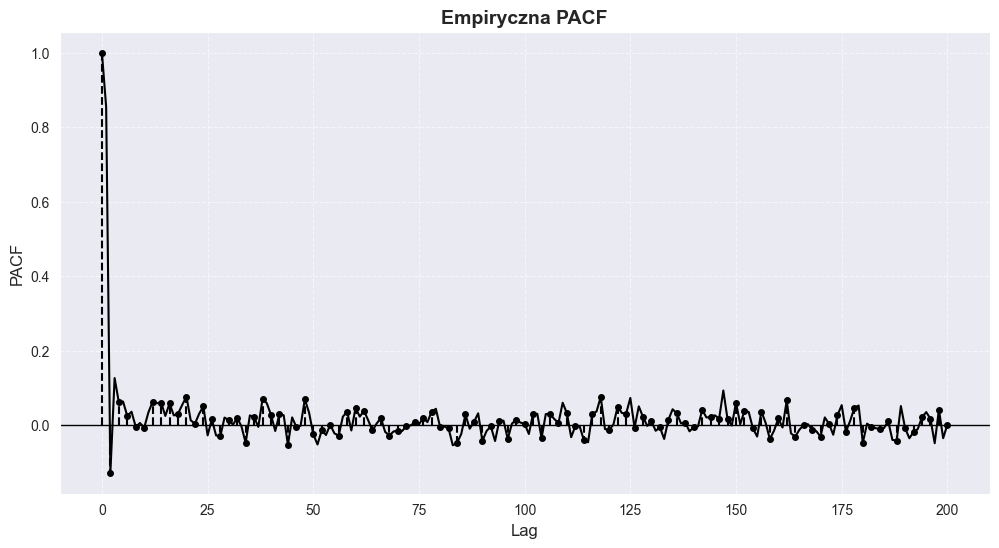

In [57]:
h_max = 200
n = len(data_cooked)
lags = np.arange(0,n)
lags_pacf = np.arange(0,h_max+1)
acvf_emp = acovf(data_cooked, fft=True)
acf_emp = acf(data_cooked, fft=True, nlags=n)
pacf_emp = pacf(data_cooked, nlags=h_max, method='yw')
step = 10

lags_sub = lags[::step]
acf_sub  = acf_emp[::step]
acvf_sub = acvf_emp[::step]


plt.figure(figsize=(12, 6))
plt.plot(lags,acvf_emp, 'k-')

markers_acvf = plt.stem(lags_sub, acvf_sub, basefmt=' ')
plt.setp(markers_acvf[0], marker='o', markersize=4, color='black')
plt.setp(markers_acvf[1], linestyle='--', color='black')

plt.xlabel('Lag',fontsize=12)
plt.ylabel('Autokowariancja',fontsize=12)
plt.title('Empiryczna autokowariancja', fontsize=14, fontweight='bold')
plt.grid(alpha=0.6, linestyle='--')
plt.axhline(y=0, color='black', linewidth=1)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(lags, acf_emp,'k-')
markers_acf = plt.stem(lags_sub, acf_sub, basefmt=' ')
plt.setp(markers_acf[0], marker='o', markersize=4, color='black')
plt.setp(markers_acf[1], linestyle='--', color='black')
plt.xlabel('Lag',fontsize=12)
plt.ylabel('Autokorelacja',fontsize=12)
plt.title('Empiryczna autokorelacja', fontsize=14, fontweight='bold')
plt.grid(alpha=0.6, linestyle='--')
plt.axhline(y=0, color='black', linewidth=1)
plt.show()

step = 2 


lags_sub2 = lags_pacf[::step]
pacf_sub  = pacf_emp[::step]

plt.figure(figsize=(12, 6))

plt.plot(lags_pacf, pacf_emp, 'k-')

markers_pacf = plt.stem(lags_sub2, pacf_sub, basefmt=' ')
plt.setp(markers_pacf[0], marker='o', markersize=4, color='black')
plt.setp(markers_pacf[1], linestyle='--', color='black')


plt.axhline(y=0, color='black', linewidth=1)
plt.title("Empiryczna PACF",fontsize=14, fontweight='bold')
plt.xlabel("Lag",fontsize=12)
plt.ylabel("PACF",fontsize=12)
plt.grid(alpha=0.6, linestyle='--')
plt.show()

# PRZEDZIAŁY UFNOŚCI DLA ACF I PACF (DO POPRAWY)

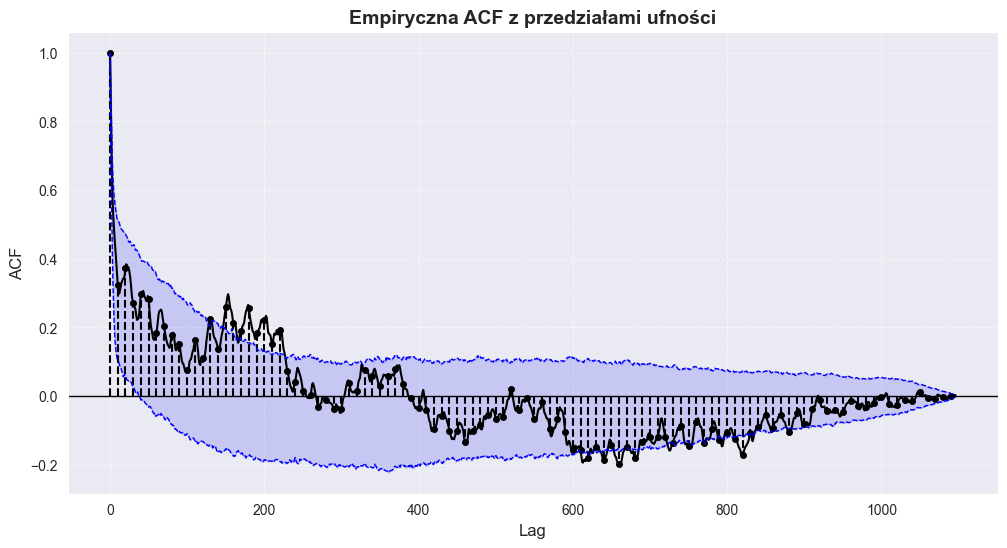

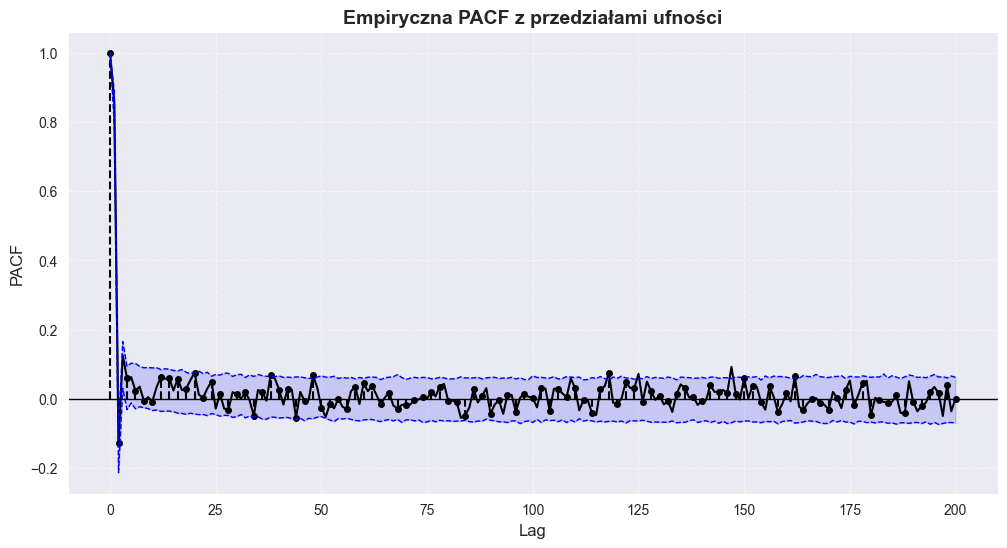

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import acf, pacf


phi1 = 1.65262043
phi2 = -0.65620510
theta1 = -0.69154668
theta2 = -0.24663048
sigma2 = 3.2178   # wariancja białego szumu

ar = np.array([1.0, -phi1, -phi2])
ma = np.array([1.0,  theta1,  theta2])

n = len(data_cooked)      # liczba obserwacji w szeregu
max_lag = n-1              # do którego opóźnienia liczymy ACF/PACF
reps = 1000              # liczba symulacji (Monte Carlo)
max_lag2=200

arma_proc = ArmaProcess(ar, ma)

# --------------------------------------------
# 2. Ustawienia Monte Carlo
# --------------------------------------------
reps = 1000                # liczba replik symulacyjnych
alpha = 0.05               # poziom istotności = 5%

# Maks. liczba lagów dla ACF i PACF
max_lag_acf = n - 1
max_lag_pacf = 200  # lub np. min(n-1, 548)

# --------------------------------------------
# 3. Obliczanie pasm ufności dla ACF (Monte Carlo)
# --------------------------------------------
acf_matrix = np.zeros((reps, max_lag_acf+1))

for i in range(reps):
    # Generujemy ścieżkę z modelu ARMA(2,2)
    sim_data = arma_proc.generate_sample(nsample=n, scale=np.sqrt(sigma2))
    # Obliczamy ACF do lag = max_lag_acf (bez alpha!)
    acf_vals = acf(sim_data, nlags=max_lag_acf, fft=True)
    acf_matrix[i, :] = acf_vals

# Empiryczne kwantyle dla każdego laga (2.5%, 97.5%)
lower_acf = np.percentile(acf_matrix, 100*alpha/2, axis=0)
upper_acf = np.percentile(acf_matrix, 100*(1-alpha/2), axis=0)

# ACF dla danych oryginalnych (stacjonarnych)
acf_vals_real = acf(data_cooked, nlags=max_lag_acf, fft=True)
lags_acf = np.arange(len(acf_vals_real))


step = 10  

# Podzbiór do rysowania stem
lags_sub = lags_acf[::step]
acf_sub  = acf_vals_real[::step]

plt.figure(figsize=(12, 6))

# 1) "Ciągła" linia (o-) łącząca wszystkie punkty ACF
plt.plot(lags_acf, acf_vals_real, 'k-')

# 2) Sub-sampling: dodajemy "stem" co step lat
markers_acf = plt.stem(lags_sub, acf_sub, basefmt=' ')
plt.setp(markers_acf[0], marker='o', markersize=4, color='black')
plt.setp(markers_acf[1], linestyle='--', color='black')

# 3) Linia i wypełnienie granic MC
plt.plot(lags_acf, lower_acf, 'b--', linewidth=1)
plt.plot(lags_acf, upper_acf, 'b--', linewidth=1)
plt.fill_between(lags_acf, lower_acf, upper_acf, color='blue', alpha=0.15)

# Dodatki
plt.axhline(y=0, color='black', linewidth=1)
plt.title("Empiryczna ACF z przedziałami ufności",fontsize=14, fontweight='bold')
plt.xlabel("Lag",fontsize=12)
plt.ylabel("ACF",fontsize=12)
plt.grid(alpha=0.6, linestyle='--')
plt.show()

# --------------------------------------------
# 4. Obliczanie pasm ufności dla PACF (Monte Carlo)
# --------------------------------------------
pacf_matrix = np.zeros((reps, max_lag_pacf+1))

for i in range(reps):
    sim_data = arma_proc.generate_sample(nsample=n, scale=np.sqrt(sigma2))
    pacf_vals = pacf(sim_data, nlags=max_lag_pacf, method='yw')
    pacf_matrix[i, :] = pacf_vals

lower_pacf = np.percentile(pacf_matrix, 100*alpha/2, axis=0)
upper_pacf = np.percentile(pacf_matrix, 100*(1-alpha/2), axis=0)

pacf_vals_real = pacf(data_cooked, nlags=max_lag_pacf, method='yw')
lags_pacf = np.arange(len(pacf_vals_real))

step = 2  # np. co 10-ty lag rysujemy słupek

# Podzbiór do rysowania stem
lags_sub2 = lags_pacf[::step]
pacf_sub  = pacf_vals_real[::step]

plt.figure(figsize=(12, 6))

# 1) "Ciągła" linia (o-) łącząca wszystkie punkty ACF
plt.plot(lags_pacf, pacf_vals_real, 'k-')

# 2) Sub-sampling: dodajemy "stem" co step lat
markers_pacf = plt.stem(lags_sub2, pacf_sub, basefmt=' ')
plt.setp(markers_pacf[0], marker='o', markersize=4, color='black')
plt.setp(markers_pacf[1], linestyle='--', color='black')

# 3) Linia i wypełnienie granic MC
plt.plot(lags_pacf, lower_pacf, 'b--', linewidth=1)
plt.plot(lags_pacf, upper_pacf, 'b--', linewidth=1)
plt.fill_between(lags_pacf, lower_pacf, upper_pacf, color='blue', alpha=0.15)

# Dodatki
plt.axhline(y=0, color='black', linewidth=1)
plt.title("Empiryczna PACF z przedziałami ufności",fontsize=14, fontweight='bold')
plt.xlabel("Lag",fontsize=12)
plt.ylabel("PACF",fontsize=12)
plt.grid(alpha=0.6, linestyle='--')
plt.show()


# Dopasowanie ARMA

In [24]:
# # Za pomocą kryteriow informacyjnych szukamy rzędu modelu, rozważamy ARMA(p,q), gdzie p, q = {0, 1, 2, 3}
# df = pd.DataFrame()

# ps = []
# qs = []
# BIC = []
# AIC = []
# HQIC = []

# # Maksymalne wartości p i q
# max_p = 5
# max_q = 5

# # Iteracja po możliwych wartościach p i q
# for p in range(0, max_p):
#     for q in range(0, max_q):
        
#         # Dopasowanie modelu ARMA dla danego p i q
#         model = ARIMA(data_cooked, order=(p, 0, q))
#         model_fit = model.fit()
        
#         # Zapisanie wartości p, q oraz wyników kryteriów informacyjnych
#         ps.append(p)
#         qs.append(q)
#         AIC.append(model_fit.aic)
#         BIC.append(model_fit.bic)
#         HQIC.append(model_fit.hqic)

# df['p']    = ps
# df['q']    = qs
# df['AIC']  = AIC
# df['BIC']  = BIC
# df['HQIC'] = HQIC

# df.sort_values(by='AIC').head(1)

In [25]:
# df.sort_values(by='BIC').head(1)

In [26]:
# df.sort_values(by='HQIC').head(1)

In [27]:
# import numpy as np
# import pandas as pd
# import statsmodels.api as sm

# # Zakładamy, że "temperature_clean" to nasz szereg już bez trendu/niesta­cjo­nar­no­ści,
# # np.: temperature_clean = temperature_without_seasonal

# lowest_aic = np.inf
# best_order = None
# best_model = None

# # Przykładowy zakres poszukiwań:
# p_values = range(0, 5)
# q_values = range(0, 5)

# for p in p_values:
#     for q in q_values:
#         try:
#             # Dopasowanie ARIMA(p,0,q), czyli de facto ARMA(p,q)
#             model = sm.tsa.ARIMA(data_cooked, order=(p, 0, q))
#             results = model.fit()

#             if results.aic < lowest_aic:
#                 lowest_aic = results.aic
#                 best_order = (p, q)
#                 best_model = results
#         except:
#             # Czasem model może się nie zbiec lub wystąpi inny błąd.
#             continue

# print("Najlepsze (p,q) wg AIC:", best_order)
# print("Najniższy AIC:", lowest_aic)

In [28]:
# import pmdarima as pm

# auto_model = pm.auto_arima(
#     data_cooked,
#     start_p=0, max_p=5,
#     start_q=0, max_q=5,
#     d=0,                # Ustawiamy d=0, żeby przeszukiwać ARMA(p,q)
#     seasonal=False,     # Zakładamy brak sezonowości (ARMA to model niese­zo­no­wy)
#     trace=True,         # Wyświetlanie kolejnych testowanych modeli
#     stepwise=False,      # Algorytm krokowy
#     information_criterion='aic'  # lub 'bic'
# )

# print(auto_model.summary())

# Wychodzi na to ze dopasowany model to ARMA(2,2)

In [58]:
p, q = 2, 2
model = ARIMA(data_cooked, order=(p, 0, q)).fit(method='innovations_mle')

print("Wyniki:")
print(model.summary())

print('\nWyliczone parametry:')
print(model.params[1:-1])


Wyniki:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1097
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -2198.447
Date:                Tue, 28 Jan 2025   AIC                           4408.893
Time:                        22:41:26   BIC                           4438.895
Sample:                             0   HQIC                          4420.245
                               - 1097                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1246      0.860     -0.145      0.885      -1.811       1.562
ar.L1          1.6526      0.044     37.226      0.000       1.566       1.740
ar.L2         -0.6562      0.043    -15.367 

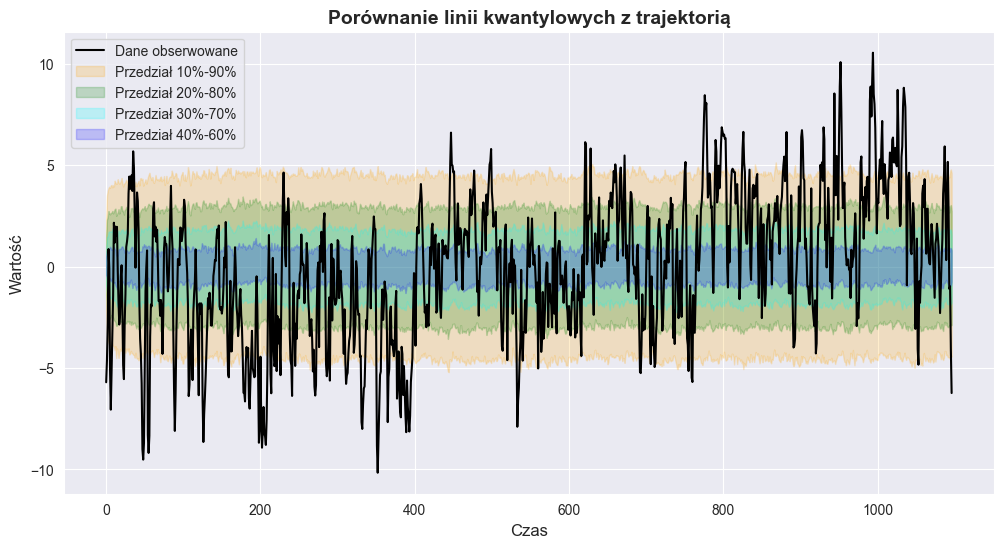

Przedział 0.1-0.9, teoretycznie 80.0%, faktycznie: 79.12%
Przedział 0.2-0.8, teoretycznie 60.00000000000001%, faktycznie: 58.89%
Przedział 0.3-0.7, teoretycznie 40.0%, faktycznie: 38.92%
Przedział 0.4-0.6, teoretycznie 19.999999999999996%, faktycznie: 19.69%


In [59]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import ArmaProcess

# Załóżmy, że masz dopasowany model ARMA(2,2):
# results = model.fit()  
# wyniki -> parametry AR(2), MA(2) i sigma2 = results.sigma2

phi1 = 1.65262043
phi2 = -0.65620510
theta1 = -0.69154668
theta2 = -0.24663048
sigma2 = 3.2178   # wariancja białego szumu

# "ar" i "ma" w konwencji ArmaProcess:
# ar = [1, -phi1, -phi2]
# ma = [1,  theta1,  theta2]
ar = np.array([1.0, -phi1, -phi2])
ma = np.array([1.0,  theta1,  theta2])

arma_proc = ArmaProcess(ar, ma)

data_length = len(data_cooked)
N = 1000  # liczba symulacji
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Macierz, w której będziemy przechowywać wszystkie sztuczne trajektorie:
sim_matrix = np.zeros((N, data_length))

for i in range(N):
    # Generujemy jedną ścieżkę z dopasowanego ARMA(2,2)
    # scale = np.sqrt(sigma2) => std dev białego szumu
    sim_path = arma_proc.generate_sample(nsample=data_length, scale=np.sqrt(sigma2))
    sim_matrix[i, :] = sim_path

# Teraz obliczamy dla każdego t (0..data_length-1) kwantyle:
lines_q = {}  # słownik: lines_q[ q ] = wektor kwantyli w czasie
for q in quantiles:
    lines_q[q] = np.percentile(sim_matrix, 100*q, axis=0)
    
# lines_q[0.1] => np.array wymiaru data_length, opisujący 10-ty percentyl w każdej chwili t

# --- Rysowanie wykresu ---
plt.figure(figsize=(12,6))
plt.plot(data_cooked, color='black', label='Dane obserwowane', linewidth=1.5)
colors = ['orange','green','cyan','blue','magenta']  # np. tyle co par kwantyli

for i, (q1,q2) in enumerate([(0.1,0.9), (0.2,0.8), (0.3,0.7), (0.4,0.6)]):
    # Rysujemy obszar pomiędzy lines_q[q1] i lines_q[q2]
    plt.fill_between(range(data_length), lines_q[q1], lines_q[q2], 
                     color=colors[i], alpha=0.2,
                     label=f'Przedział {int(q1*100)}%-{int(q2*100)}%')

plt.title('Porównanie linii kwantylowych z trajektorią',fontsize=14, fontweight='bold')
plt.xlabel('Czas',fontsize=12)
plt.ylabel('Wartość',fontsize = 12)
plt.legend()
plt.show()

# --- Sprawdzenie, jaki odsetek punktów mieści się w danym przedziale ---
intervals = [(0.1,0.9), (0.2,0.8), (0.3,0.7), (0.4,0.6)]
for (q1,q2) in intervals:
    lower = lines_q[q1]
    upper = lines_q[q2]
    in_count = np.sum((data_cooked >= lower) & (data_cooked <= upper))
    in_percent = 100 * in_count / data_length
    print(f"Przedział {q1}-{q2}, teoretycznie {(q2-q1)*100}%, faktycznie: {in_percent:.2f}%")


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


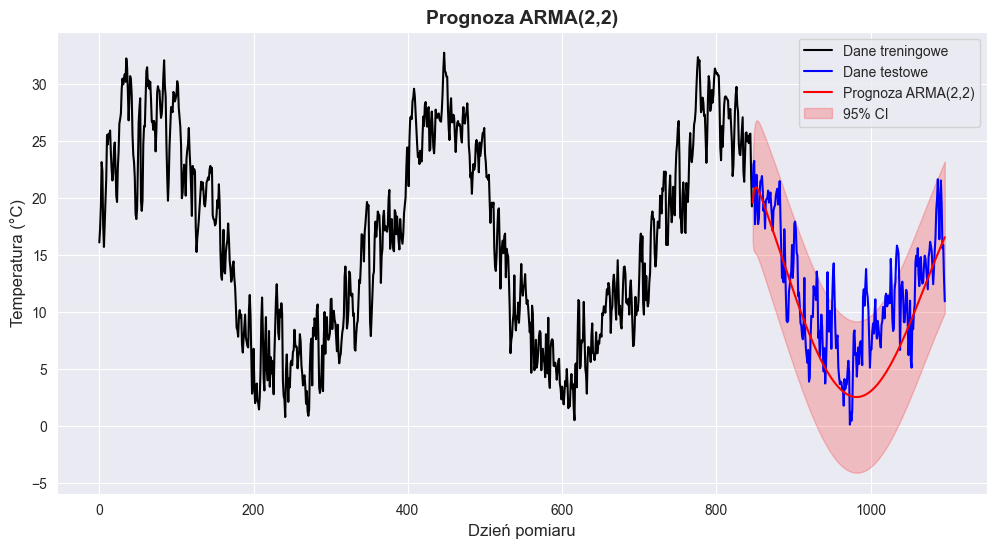

MSE prognozy = 16.594681692858643


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

# ======================
# USTAWIENIA WSTĘPNE 
# ======================
# 1. Parametry ARMA(2,2) "na sztywno":
phi1 = 1.65262043
phi2 = -0.65620510
theta1 = -0.69154668
theta2 = -0.24663048
sigma2 = 3.2178   # wariancja białego szumu

# 2. Liczba kroków w przód
N_FORECAST = 250  

# =========================================
# (A) PRZYGOTOWANIE DANYCH (TREND + SEZON)
# =========================================
# Zakładamy, że 'madrid_data' to DataFrame z kolumną 'AvgTemperature'
# i indeksem 0..n-1 (dzień pomiaru).
time = np.arange(len(madrid_data))
temperature = madrid_data['AvgTemperature'].values

# A1) Usunięcie TRENDu
linear_reg = LinearRegression()
linear_reg.fit(time.reshape(-1, 1), temperature)
trend_pred = linear_reg.predict(time.reshape(-1, 1))
temp_no_trend = temperature - trend_pred

# A2) Usunięcie SEZONu (sinus)
def sine_func(x, A, omega, phi, offset):
    return offset + A*np.sin(omega*x + phi)

p0 = [10, 2*np.pi/365, 0, 0]  # początkowe parametry sinusoidy
params, _ = curve_fit(sine_func, time, temp_no_trend, p0=p0)
fitted_sine = sine_func(time, *params)
temp_no_season = temp_no_trend - fitted_sine

# "temp_no_season" to nasz szereg odsezonowany

# ============================
# (B) PODZIAŁ TRAIN / TEST
# ============================
train_orig = temperature[:-N_FORECAST]  # oryg. dane uczące
test_orig  = temperature[-N_FORECAST:]  # oryg. dane testowe
train_cooked = temp_no_season[:-N_FORECAST]
test_cooked  = temp_no_season[-N_FORECAST:]
train_time   = time[:-N_FORECAST]
test_time    = time[-N_FORECAST:]

# ============================
# (C) DOPASOWANIE "FAKE" ARMA(2,2) 
# z RĘCZNIE WSTAWIONYMI PARAMETRAMI
# ============================
# Idea: "udajemy", że statsmodels ma te parametry. 
# W starych wersjach można było wstawić parametry do ARMAProcess; 
# Tu spróbujemy: 
#  1) Dopasować model do train_cooked
#  2) Nadpisać wewnętrzne parametry na te ręcznie wyznaczone 
#  3) Używać metody get_forecast

arma_model = ARIMA(train_cooked, order=(2,0,2))
results_fit = arma_model.fit()

# Nadpisujemy parametry arparams, maparams, sigma2. 
# (Tak naprawdę statsmodels ma parametry w results_fit.params, ale tu obejście.)
results_fit.arparams = np.array([phi1, phi2]) 
results_fit.maparams = np.array([theta1, theta2]) 
results_fit.sigma2   = sigma2

# ============================
# (D) PROGNOZA w odsezonowanej skali
# ============================
fc_res = results_fit.get_forecast(steps=N_FORECAST)
pred_mean_cooked = fc_res.predicted_mean

# w starszych statsmodels conf_int -> DataFrame lub np.array
conf_cooked = fc_res.conf_int(alpha=0.05)
if isinstance(conf_cooked, np.ndarray):
    pred_lower_cooked = conf_cooked[:,0]
    pred_upper_cooked = conf_cooked[:,1]
else:
    pred_lower_cooked = conf_cooked.iloc[:,0]
    pred_upper_cooked = conf_cooked.iloc[:,1]

# ============================
# (E) ODTWORZENIE SKALI Oryginalnej
# ============================
def inverse_transform(cooked_vals, idx):
    trend_part = linear_reg.predict(idx.reshape(-1,1))
    season_part = sine_func(idx, *params)
    return cooked_vals + trend_part + season_part

pred_mean_orig  = inverse_transform(pred_mean_cooked,  test_time)
pred_lower_orig = inverse_transform(pred_lower_cooked, test_time)
pred_upper_orig = inverse_transform(pred_upper_cooked, test_time)


plt.figure(figsize=(12,6))
# Train
plt.plot(train_time, train_orig, label='Dane treningowe', color='black')
# Test
plt.plot(test_time, test_orig, label='Dane testowe', color='blue')
# Prognoza 
plt.plot(test_time, pred_mean_orig, label='Prognoza ARMA(2,2)', color='red')
plt.fill_between(test_time, pred_lower_orig, pred_upper_orig, alpha=0.2, color='red', label='95% CI')
plt.xlabel('Dzień pomiaru',fontsize = 12)
plt.ylabel('Temperatura (°C)',fontsize = 12)
plt.title('Prognoza ARMA(2,2)',fontsize=14, fontweight='bold')
plt.legend()
plt.show()

# ============================
# (G) OBLICZENIE MSE
# ============================
mse = np.mean((pred_mean_orig - test_orig)**2)
print("MSE prognozy =", mse)


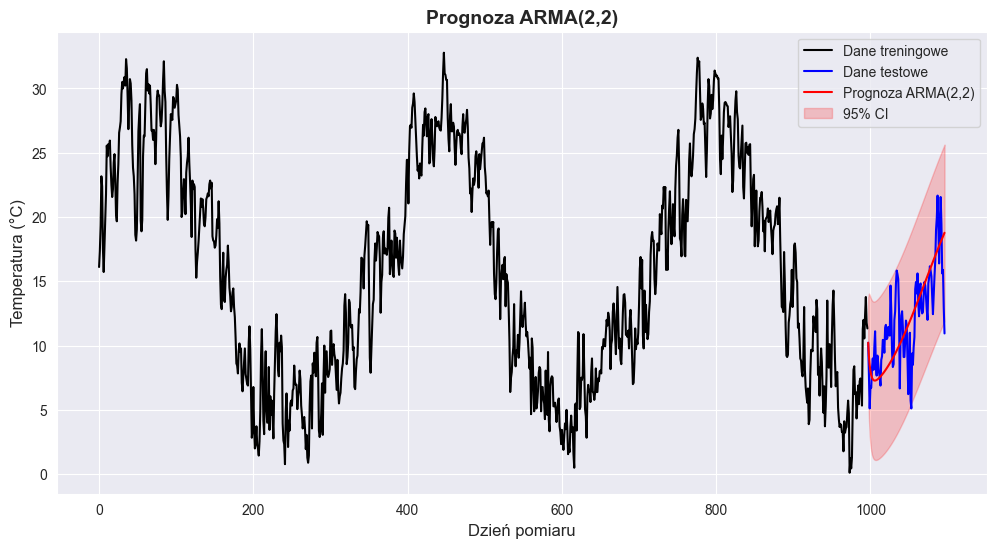

MSE prognozy = 7.65493671085723


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

# ======================
# USTAWIENIA WSTĘPNE 
# ======================
# 1. Parametry ARMA(2,2) "na sztywno":
phi1 = 1.65262043
phi2 = -0.65620510
theta1 = -0.69154668
theta2 = -0.24663048
sigma2 = 3.2178   # wariancja białego szumu

# 2. Liczba kroków w przód
N_FORECAST = 100 

# =========================================
# (A) PRZYGOTOWANIE DANYCH (TREND + SEZON)
# =========================================
# Zakładamy, że 'madrid_data' to DataFrame z kolumną 'AvgTemperature'
# i indeksem 0..n-1 (dzień pomiaru).
time = np.arange(len(madrid_data))
temperature = madrid_data['AvgTemperature'].values

# A1) Usunięcie TRENDu
linear_reg = LinearRegression()
linear_reg.fit(time.reshape(-1, 1), temperature)
trend_pred = linear_reg.predict(time.reshape(-1, 1))
temp_no_trend = temperature - trend_pred

# A2) Usunięcie SEZONu (sinus)
def sine_func(x, A, omega, phi, offset):
    return offset + A*np.sin(omega*x + phi)

p0 = [10, 2*np.pi/365, 0, 0]  # początkowe parametry sinusoidy
params, _ = curve_fit(sine_func, time, temp_no_trend, p0=p0)
fitted_sine = sine_func(time, *params)
temp_no_season = temp_no_trend - fitted_sine

# "temp_no_season" to nasz szereg odsezonowany

# ============================
# (B) PODZIAŁ TRAIN / TEST
# ============================
train_orig = temperature[:-N_FORECAST]  # oryg. dane uczące
test_orig  = temperature[-N_FORECAST:]  # oryg. dane testowe
train_cooked = temp_no_season[:-N_FORECAST]
test_cooked  = temp_no_season[-N_FORECAST:]
train_time   = time[:-N_FORECAST]
test_time    = time[-N_FORECAST:]

# ============================
# (C) DOPASOWANIE "FAKE" ARMA(2,2) 
# z RĘCZNIE WSTAWIONYMI PARAMETRAMI
# ============================
# Idea: "udajemy", że statsmodels ma te parametry. 
# W starych wersjach można było wstawić parametry do ARMAProcess; 
# Tu spróbujemy: 
#  1) Dopasować model do train_cooked
#  2) Nadpisać wewnętrzne parametry na te ręcznie wyznaczone 
#  3) Używać metody get_forecast

arma_model = ARIMA(train_cooked, order=(2,0,2))
results_fit = arma_model.fit()

# Nadpisujemy parametry arparams, maparams, sigma2. 
# (Tak naprawdę statsmodels ma parametry w results_fit.params, ale tu obejście.)
results_fit.arparams = np.array([phi1, phi2]) 
results_fit.maparams = np.array([theta1, theta2]) 
results_fit.sigma2   = sigma2

# ============================
# (D) PROGNOZA w odsezonowanej skali
# ============================
fc_res = results_fit.get_forecast(steps=N_FORECAST)
pred_mean_cooked = fc_res.predicted_mean

# w starszych statsmodels conf_int -> DataFrame lub np.array
conf_cooked = fc_res.conf_int(alpha=0.05)
if isinstance(conf_cooked, np.ndarray):
    pred_lower_cooked = conf_cooked[:,0]
    pred_upper_cooked = conf_cooked[:,1]
else:
    pred_lower_cooked = conf_cooked.iloc[:,0]
    pred_upper_cooked = conf_cooked.iloc[:,1]

# ============================
# (E) ODTWORZENIE SKALI Oryginalnej
# ============================
def inverse_transform(cooked_vals, idx):
    trend_part = linear_reg.predict(idx.reshape(-1,1))
    season_part = sine_func(idx, *params)
    return cooked_vals + trend_part + season_part

pred_mean_orig  = inverse_transform(pred_mean_cooked,  test_time)
pred_lower_orig = inverse_transform(pred_lower_cooked, test_time)
pred_upper_orig = inverse_transform(pred_upper_cooked, test_time)

# ============================
# (F) RYSOWANIE 
# ============================
plt.figure(figsize=(12,6))
# Train
plt.plot(train_time, train_orig, label='Dane treningowe', color='black')
# Test
plt.plot(test_time, test_orig, label='Dane testowe', color='blue')
# Prognoza 
plt.plot(test_time, pred_mean_orig, label='Prognoza ARMA(2,2)', color='red')
plt.fill_between(test_time, pred_lower_orig, pred_upper_orig, alpha=0.2, color='red', label='95% CI')
plt.xlabel('Dzień pomiaru', fontsize = 12)
plt.ylabel('Temperatura (°C)', fontsize = 12)
plt.title('Prognoza ARMA(2,2)',fontsize=14, fontweight='bold')
plt.legend()
plt.show()

# ============================
# (G) OBLICZENIE MSE
# ============================
mse = np.mean((pred_mean_orig - test_orig)**2)
print("MSE prognozy =", mse)


# Residua

Średnia reszt = 0.012860732527102438
Odchylenie standardowe reszt = 1.8007323812910137
Wariancja reszt = 3.242637109030005


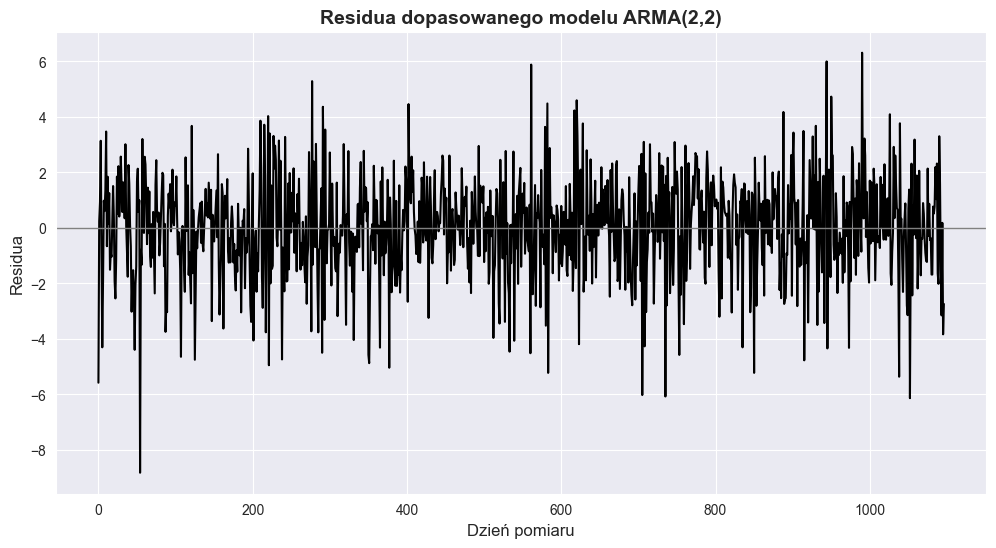

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Załóżmy, że 'data_cooked' to nasz szereg po usunięciu trendu i sezonowości
# i chcemy dopasować do niego model ARMA(2,2) na podstawie poprzednich analiz

# 1. Definicja modelu ARIMA(p=2,d=0,q=2) = ARMA(2,2)
model = sm.tsa.ARIMA(data_cooked, order=(2,0,2))

# 2. Dopasowanie metodą MLE
results = model.fit()

# 3. Wyciągamy "klasyczne" residua:
residuals = results.resid

# 4. Statystyki opisowe reszt
res_mean = np.mean(residuals)
res_var  = np.var(residuals, ddof=1)  # ddof=1, by pasować do definicji statyst. próbkowych
res_std  = np.sqrt(res_var)

print("Średnia reszt =", res_mean)
print("Odchylenie standardowe reszt =", res_std)
print("Wariancja reszt =", res_var)

# 5. Wykres reszt
plt.figure(figsize=(12,6))
plt.plot(residuals, color = 'black' )
plt.axhline(y=0, color='grey', linewidth=1)
plt.title("Residua dopasowanego modelu ARMA(2,2)", fontsize=14, fontweight='bold')
plt.xlabel("Dzień pomiaru", fontsize=12)
plt.ylabel("Residua", fontsize=12)
plt.show()


# stałość wariancji

In [36]:
arch_test = het_arch(residuals)
print("Statystyka testu:", arch_test[0])
print("P-wartość:", arch_test[1])
print("Liczba obserwacji:", arch_test[2])
print("Wartości krytyczne:", arch_test[3])

# Interpretacja wyniku
alpha = 0.05  # Poziom istotności
if arch_test[1] < alpha:
    print(f"P-wartość ({arch_test[1]:.4f}) jest mniejsza od {alpha}. Wariancja nie jest stała (efekt ARCH).")
else:
    print(f"P-wartość ({arch_test[1]:.4f}) jest większa od {alpha}. Wariancja jest stała (brak efektu ARCH).")


Statystyka testu: 22.943555528338457
P-wartość: 0.010956852656598785
Liczba obserwacji: 2.3201086631029453
Wartości krytyczne: 0.010601376822769472
P-wartość (0.0110) jest mniejsza od 0.05. Wariancja nie jest stała (efekt ARCH).


# Niezależność reszt

In [37]:
ljung_box_test = acorr_ljungbox(residuals, lags=len(residuals)-1, return_df=True)

# Wyświetlenie wyników
print(ljung_box_test)

# Interpretacja wyniku dla pierwszego opóźnienia
alpha = 0.05
print(np.mean(ljung_box_test['lb_stat']))
p_value = ljung_box_test['lb_pvalue'].iloc[0]  # P-wartość dla pierwszego lags
if p_value < alpha:
    print(f"P-wartość ({p_value:.4f}) jest mniejsza od {alpha}. Dane wykazują autokorelację (odrzucamy H0).")
else:
    print(f"P-wartość ({p_value:.4f}) jest większa od {alpha}. Dane nie wykazują autokorelacji (nie ma podstaw do odrzucenia H0).")


          lb_stat  lb_pvalue
1        0.008053   0.928494
2        0.096897   0.952707
3        0.201997   0.977266
4        0.242680   0.993208
5        1.573446   0.904442
...           ...        ...
1092  1165.373498   0.060524
1093  1166.106711   0.061265
1094  1166.723588   0.062303
1095  1187.491456   0.026341
1096  1210.105434   0.008858

[1096 rows x 2 columns]
526.4893558227157
P-wartość (0.9285) jest większa od 0.05. Dane nie wykazują autokorelacji (nie ma podstaw do odrzucenia H0).


# normalność rozkładu

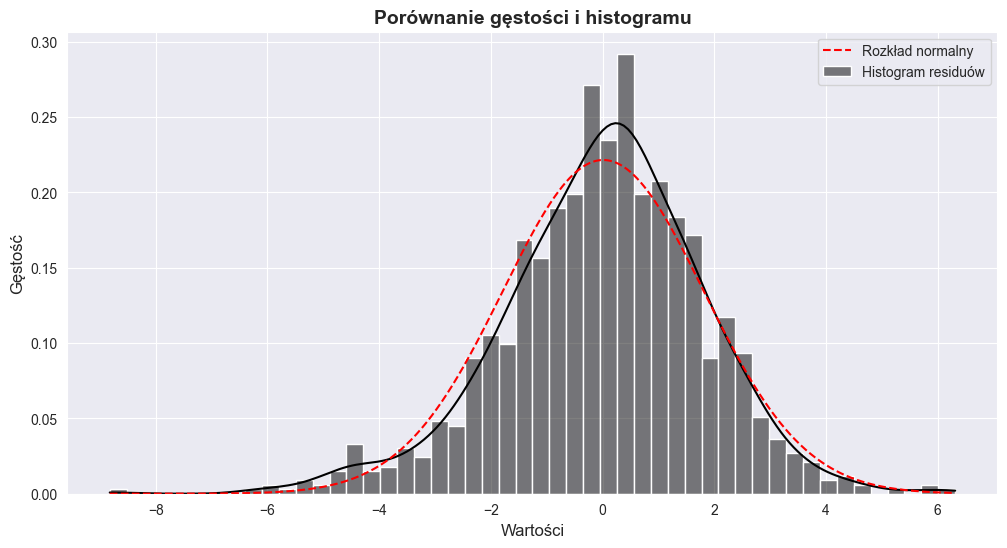

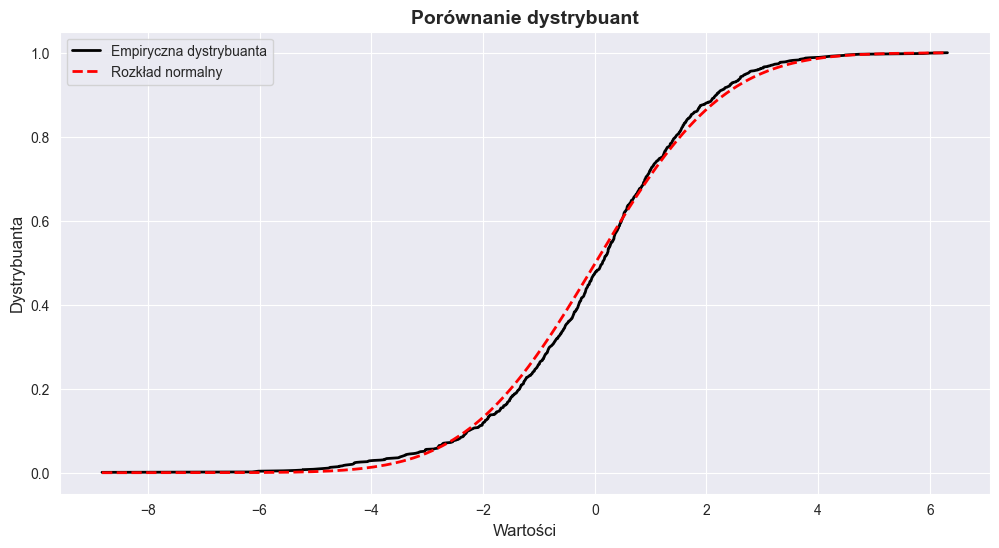

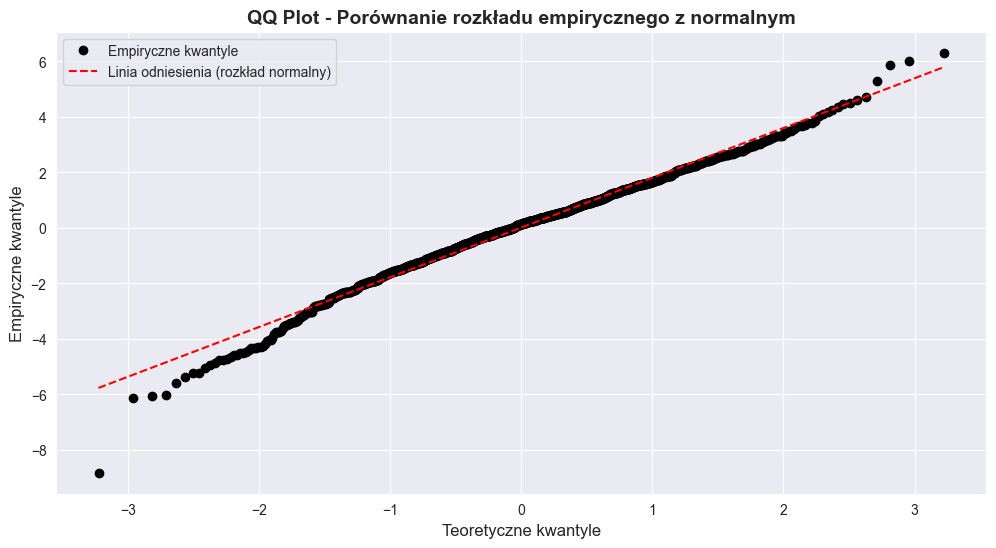

0.9880810976028442 8.762974346154806e-08
Odrzucenie H0. Dane nie pochodzą z rozkładu normalnego.


In [69]:
mean = np.mean(residuals)
var  = np.var(residuals, ddof=1)  # ddof=1, by pasować do definicji statyst. próbkowych
std  = np.sqrt(var)
x = np.linspace(min(residuals), max(residuals), 1000)
normal_density = norm.pdf(x, loc=mean, scale=std)

plt.figure(figsize=(12, 6))
sns.histplot(residuals, stat='density', bins = 50, label='Histogram residuów', color='black', kde=True)
plt.plot(x, normal_density, label='Rozkład normalny', color='red', linestyle = '--')
plt.legend()
plt.xlabel('Wartości', fontsize=12)
plt.ylabel('Gęstość', fontsize=12)
plt.title('Porównanie gęstości i histogramu',fontsize = 14, fontweight = 'bold')
plt.show()

sorted_residuals = np.sort(residuals)
empirical_cdf = np.arange(1, len(residuals) + 1) / len(residuals)
normal_cdf = norm.cdf(sorted_residuals, loc=mean, scale=std)

plt.figure(figsize=(12, 6))
plt.plot(sorted_residuals, empirical_cdf, label='Empiryczna dystrybuanta', color='black', linewidth = '2')
plt.plot(sorted_residuals, normal_cdf, label='Rozkład normalny', color='red', linestyle = '--',linewidth = '2')
plt.legend()
plt.xlabel('Wartości', fontsize=12)
plt.ylabel('Dystrybuanta', fontsize=12)
plt.title('Porównanie dystrybuant',fontsize = 14, fontweight = 'bold')
plt.show()

plt.figure(figsize=(12, 6))
probplot(residuals, dist="norm", plot=plt)
plt.gca().get_lines()[1].set_linestyle('--')  
plt.gca().get_lines()[1].set_color('red')   
plt.gca().get_lines()[0].set_color('black')   
plt.gca().get_lines()[0].set_marker('o') 
plt.legend(["Empiryczne kwantyle","Linia odniesienia (rozkład normalny)"], loc='best')   
plt.title("QQ Plot - Porównanie rozkładu empirycznego z normalnym",fontsize = 14, fontweight = 'bold')
plt.xlabel("Teoretyczne kwantyle", fontsize=12)
plt.ylabel("Empiryczne kwantyle", fontsize=12)
plt.show()

shapiro_stat, shapiro_p  = shapiro(residuals)
print(shapiro_stat, shapiro_p )
if shapiro_p  > 0.05:
    ks_interp = print("Brak podstaw do odrzucenia H0")
else:
    ks_interp = print("Odrzucenie H0. Dane nie pochodzą z rozkładu normalnego.")


In [39]:
import numpy as np
from scipy.stats import shapiro, anderson, normaltest, jarque_bera

# Załóżmy, że 'residuals' to nasz wektor reszt dopasowanego modelu, np. ARMA(2,2)

# Shapiro-Wilk
stat_sw, p_sw = shapiro(residuals)
print(f"Shapiro-Wilk test: stat={stat_sw:.4f}, p-value={p_sw:.4g}")
if p_sw < 0.05:
    print("Odrzucenie H0 => rozkład nie jest normalny na poziomie 5%.")
else:
    print("Brak podstaw do odrzucenia H0 => rozkład może być normalny.")

# Anderson-Darling
result_ad = anderson(residuals, dist='norm')
print(f"\nAnderson-Darling stat={result_ad.statistic:.4f}")
for i, (sl, cv) in enumerate(zip(result_ad.significance_level, result_ad.critical_values)):
    if result_ad.statistic > cv:
        print(f"Poziom istotności {sl}%, stat > krytyczna => odrzucamy H0")
    else:
        print(f"Poziom istotności {sl}%, stat < krytyczna => brak podstaw do odrzucenia H0")

# Jarque-Bera
jb_stat, jb_p, skew, kurt = jarque_bera(residuals)
print(f"\nJarque-Bera test: stat={jb_stat:.4f}, p-value={jb_p:.4g}")
if jb_p < 0.05:
    print("Odrzucenie H0 => rozkład nie jest normalny na poziomie 5%.")
else:
    print("Brak podstaw do odrzucenia H0 => rozkład może być normalny.")

# D'Agostino K^2 test (normaltest)
stat_k2, p_k2 = normaltest(residuals)
print(f"\nD'Agostino K^2 test: stat={stat_k2:.4f}, p-value={p_k2:.4g}")
if p_k2 < 0.05:
    print("Odrzucenie H0 => rozkład nie jest normalny na poziomie 5%.")
else:
    print("Brak podstaw do odrzucenia H0 => rozkład może być normalny.")


Shapiro-Wilk test: stat=0.9881, p-value=8.757e-08
Odrzucenie H0 => rozkład nie jest normalny na poziomie 5%.

Anderson-Darling stat=2.8356
Poziom istotności 15.0%, stat > krytyczna => odrzucamy H0
Poziom istotności 10.0%, stat > krytyczna => odrzucamy H0
Poziom istotności 5.0%, stat > krytyczna => odrzucamy H0
Poziom istotności 2.5%, stat > krytyczna => odrzucamy H0
Poziom istotności 1.0%, stat > krytyczna => odrzucamy H0


ValueError: not enough values to unpack (expected 4, got 2)